<a href="https://colab.research.google.com/github/msdkhairi/cartpole/blob/master/DL_HW6_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## solving Cartpole with a deep model 

In [0]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

In [0]:

class Agent:
    def __init__(self, learning_rate):
        # Build the network to predict the correct action
        tf.reset_default_graph()
        input_dimension = 4
        hidden_dimension = 32
        self.input = tf.placeholder(dtype=tf.float32, shape=[1, input_dimension], name='X')
        hidden_layer = tf.contrib.layers.fully_connected(self.input, hidden_dimension, tf.nn.relu)
        self.logits = tf.contrib.layers.fully_connected(hidden_layer, 2, None)

        # Sample an action according to network's output
        # use tf.multinomial and sample one action from network's output
        self.action = tf.squeeze(tf.multinomial(self.logits, 1), 1)

        # Optimization according to policy gradient algorithm
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.action)
        self.optimizer = tf.train.AdamOptimizer(learning_rate)  # use one of tensorflow optimizers
        grads_vars = self.optimizer.compute_gradients(
            cross_entropy)  # gradient of current action w.r.t. network's variables
        self.gradients = [grad for grad, var in grads_vars]

        # get rewards from the environment and evaluate rewarded gradients
        #  and feed it to agent and then call train operation
        self.rewarded_grads_placeholders_list = []
        rewarded_grads_and_vars = []
        for grad, var in grads_vars:
            rewarded_grad_placeholder = tf.placeholder(dtype=tf.float32, shape=grad.shape)
            self.rewarded_grads_placeholders_list.append(rewarded_grad_placeholder)
            rewarded_grads_and_vars.append((rewarded_grad_placeholder, var))

        self.train_operation = self.optimizer.apply_gradients(rewarded_grads_and_vars)

        self.saver = tf.train.Saver()

        config = tf.ConfigProto(
            device_count={'GPU': 0}
        )

        self.ses = tf.Session(config=config)
        self.ses.run(tf.global_variables_initializer())
        
    def get_policy(self, obs):
        policy = self.ses.run(tf.nn.softmax(self.logits), feed_dict={self.input: [obs]})
        return policy

    def get_action_and_gradients(self, obs):
        # compute network's action and gradients given the observations
        action, gradients = self.ses.run([self.action, self.gradients], feed_dict={self.input: [obs]})
        return action, gradients

    def train(self, rewarded_gradients):
        feed_dict = {self.rewarded_grads_placeholders_list[i]: 
                     rewarded_gradients[i] for i in range(len(self.rewarded_grads_placeholders_list))}
        # feed gradients into the placeholder and call train operation
        self.ses.run(self.train_operation, feed_dict=feed_dict)

    def save(self):
        self.saver.save(self.ses, "SavedModel/")

    def load(self):
        self.saver.restore(self.ses, "SavedModel/")



In [0]:
def mult_grad(grad, coef):
    """ multiplies grad by coef 
    """    
    return [coef * grad[i] for i in range(len(grad))]

def sum_gradients(grad1, grad2):
    """ add two gradients """
    grad = []
    for i in range(len(grad1)):
        grad.append(grad1[i]+grad2[i])
    return grad

def sum_list_gradients(gradients):
    """ get a list of gradients and return the sum 
    """
    grad = gradients[0]
    for i in range(len(gradients)-1):
        grad = sum_gradients(grad, gradients[i+1])
    return grad

def sum_all_list_gradients(epoch_gradients, rewards):
    """ get a list of list of gradients and return the weighted sum
        the weight is rewards
    """
    num_games = len(epoch_gradients)
    grad = sum_list_gradients(epoch_gradients[0])
    grad = mult_grad(grad, rewards[0])
    for i in range(num_games - 1):
        grad = sum_gradients(grad, mult_grad(sum_list_gradients(epoch_gradients[i+1]), rewards[i+1]))

    return grad

In [0]:
epochs = 100
max_steps_per_game = 1000
games_per_epoch = 20
discount_factor = 0.95
learning_rate = 0.01

## Train the network with discount factor 0.95

In [0]:
agent = Agent(learning_rate)
game = gym.make("CartPole-v0").env
for epoch in range(epochs):
    epoch_rewards = []
    epoch_gradients = []
    epoch_average_reward = 0
    for episode in range(games_per_epoch):
        obs = game.reset()
        step = 0
        single_episode_rewards = []
        single_episode_gradients = []
        game_over = False
        while not game_over and step < max_steps_per_game:
            step += 1
            # image = game.render(mode='rgb_array') # Call this to render game and show visual
            action, gradients = agent.get_action_and_gradients(obs)
            obs, reward, game_over, info = game.step(action.item())
            single_episode_rewards.append(reward)
            single_episode_gradients.append(gradients)

        epoch_rewards.append(single_episode_rewards)
        epoch_gradients.append(single_episode_gradients)
        epoch_average_reward += sum(single_episode_rewards)

    epoch_average_reward /= games_per_epoch
    print("Epoch = {}, , Average reward = {}".format(epoch, epoch_average_reward))

    # TODO: normalized_rewards and mean_rewarded_gradients should be assigned with correct values
    normalized_rewards = [sum(reward)*(discount_factor**i) - epoch_average_reward for i, reward in enumerate(epoch_rewards)]
    mean_rewarded_gradients = sum_all_list_gradients(epoch_gradients, normalized_rewards)

    agent.train(mean_rewarded_gradients)
    
    

agent.save()
game.close()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Epoch = 0, , Average reward = 18.45
Epoch = 1, , Average reward = 22.35
Epoch = 2, , Average reward = 27.1
Epoch = 3, , Average reward = 21.6
Epoch = 4, , Average reward = 33.25
Epoch = 5, , Average reward = 30.45
Epoch = 6, , Average reward = 31.1
Epoch = 7, , Average reward = 33.65
Epoch = 8, , Average reward = 42.1
Epoch = 9, , Average reward = 34.7
Epoch = 10, , Average reward = 57.45
Epoch = 11, , Average reward = 49.2
Epoch = 12, , Average reward = 50.85
Epoch = 13, , Average reward = 41.35
Epoch = 14, , Average reward = 45.65
Epoch = 15, , Average reward = 55.05
Epoch = 16, , Average reward = 54.0
Epoch = 17, , Aver

## Test the network with max_steps = 2000

In [0]:
# Run this part after training the network
agent = Agent(0)
game = gym.make("CartPole-v0").env
agent.load()
max_steps = 2000
score = 0
for i in range(10):
    obs = game.reset()
    game_over = False
    step = 0
    while not game_over and step < max_steps:
        step += 1
        score += 1
        # image = game.render(mode='rgb_array')  # Call this to render game and show visual
        action, _ = agent.get_action_and_gradients(obs)
        obs, reward, game_over, info = game.step(action.item())

print("Average Score = ", score / 10)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from SavedModel/
Average Score =  1740.4


## Train the network with different discount factors and plotting the average rewards during the training for each discount factor

In [0]:
def train(discount_factor, epochs=100):
    """ train the network with given discount factor
        return list of epoch_average_reward
    """
    
    print('Discount factor =', discount_factor)
    agent = Agent(learning_rate)
    game = gym.make("CartPole-v0").env
    epoch_average_rewards = []
    for epoch in range(epochs):
        epoch_rewards = []
        epoch_gradients = []
        epoch_average_reward = 0
        for episode in range(games_per_epoch):
            obs = game.reset()
            step = 0
            single_episode_rewards = []
            single_episode_gradients = []
            game_over = False
            while not game_over and step < max_steps_per_game:
                step += 1
                # image = game.render(mode='rgb_array') # Call this to render game and show visual
                action, gradients = agent.get_action_and_gradients(obs)
                obs, reward, game_over, info = game.step(action.item())
                single_episode_rewards.append(reward)
                single_episode_gradients.append(gradients)

            epoch_rewards.append(single_episode_rewards)
            epoch_gradients.append(single_episode_gradients)
            epoch_average_reward += sum(single_episode_rewards)

        epoch_average_reward /= games_per_epoch
        epoch_average_rewards.append(epoch_average_reward)
#         print("Epoch = {}, , Average reward = {}".format(epoch, epoch_average_reward))

        # TODO: normalized_rewards and mean_rewarded_gradients should be assigned with correct values
        normalized_rewards = [sum(reward)*(discount_factor**i) - epoch_average_reward for i, reward in enumerate(epoch_rewards)]
        mean_rewarded_gradients = sum_all_list_gradients(epoch_gradients, normalized_rewards)

        agent.train(mean_rewarded_gradients)
    
    print('Training Done!')
    return epoch_average_rewards


In [0]:
discount_factors = [0.85, 0.9, 0.925, 0.95, 0.975, 0.995]
rewards = []
for discount_factor in discount_factors:
    rewards.append(train(discount_factor, epochs=100))

Discount factor = 0.85
Training Done
Discount factor = 0.9
Training Done
Discount factor = 0.925
Training Done
Discount factor = 0.95
Training Done
Discount factor = 0.975
Training Done
Discount factor = 0.995
Training Done


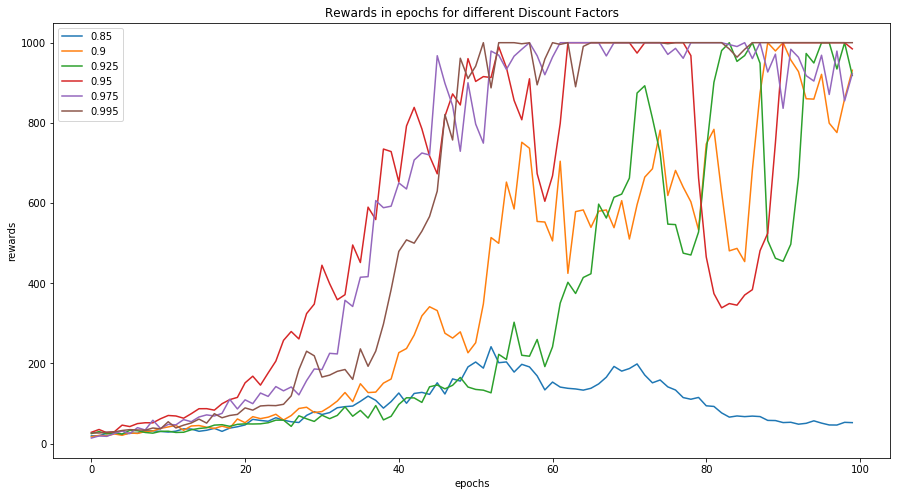

In [0]:
plt.figure(figsize=(15,8))
for df, reward_epoch in zip(discount_factors,rewards):
    plt.plot(reward_epoch, label=df)
plt.title('Rewards in epochs for different Discount Factors')
plt.xlabel('epochs'), plt.ylabel('rewards')
plt.legend()
plt.show()
    

## Some Visualizing

### velocity and angle

In [0]:
num_steps = 1000
myplot1 = np.zeros((2, num_steps))
actions1 = np.zeros(num_steps)
for i in range(num_steps):
    
    vel = np.random.uniform(-10, 10)
    ang = np.random.uniform(np.radians(-12), np.radians(12))
    
#     actions1[i] = np.argmax(agent.get_policy([0, vel, ang, 0]))
    # the probability of going right
    actions1[i] = agent.get_policy([0, vel, ang, 0])[0][1]
    myplot1[0, i] = vel
    myplot1[1, i] = ang

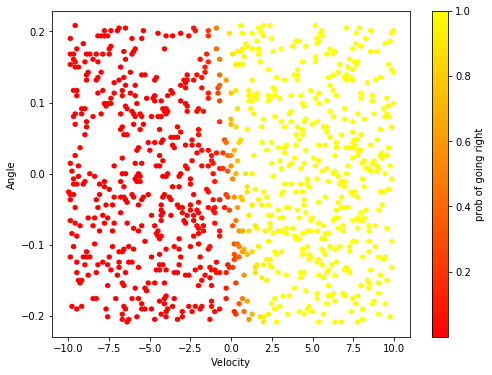

In [0]:
plt.figure(figsize=(8,6))
plt.hexbin(myplot1[0], myplot1[1], C=actions1, linewidths=2, cmap='autumn')
plt.xlabel('Velocity'), plt.ylabel('Angle')
cb = plt.colorbar()
cb.set_label('prob of going right')
plt.show()

### velocity and angular velocity

In [0]:
num_steps = 1000
myplot2 = np.zeros((2, num_steps))
actions2 = np.zeros(num_steps)
for i in range(num_steps):
    
    vel = np.random.uniform(-10, 10)
    ang_vel = np.random.uniform(-10, 10)
    
    # the probability of going right
    actions2[i] = agent.get_policy([0, vel, 0, ang_vel])[0][1]
    myplot2[0, i] = vel
    myplot2[1, i] = ang_vel

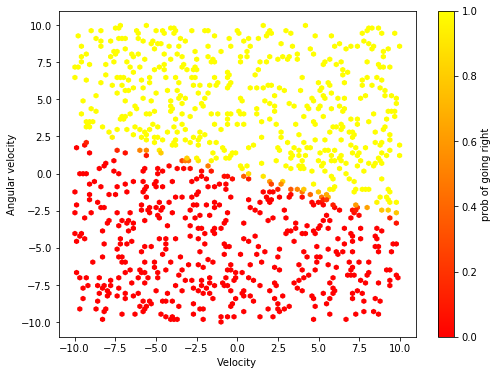

In [0]:
plt.figure(figsize=(8,6))
plt.hexbin(myplot2[0], myplot2[1], C=actions2, linewidths=2, cmap='autumn')
plt.xlabel('Velocity'), plt.ylabel('Angular velocity')
cb = plt.colorbar()
cb.set_label('prob of going right')
plt.show()

### angle and angular velocity

In [0]:
num_steps = 1000
myplot3 = np.zeros((2, num_steps))
actions3 = np.zeros(num_steps)
for i in range(num_steps):
    
    ang = np.random.uniform(np.radians(-12), np.radians(12))
    ang_vel = np.random.uniform(-10, 10)
    
    # the probability of going right
    actions3[i] = agent.get_policy([0, 0, ang, ang_vel])[0][1]
    myplot3[0, i] = ang
    myplot3[1, i] = ang_vel

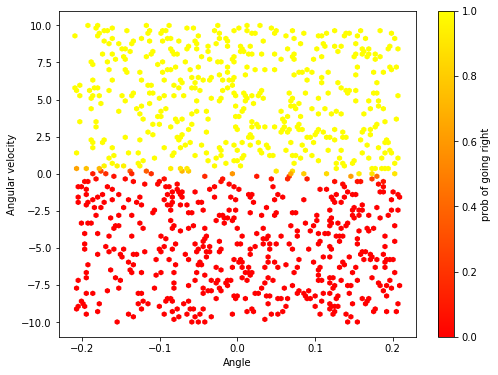

In [0]:
plt.figure(figsize=(8,6))
plt.hexbin(myplot3[0], myplot3[1], C=actions3, linewidths=2, cmap='autumn')
plt.xlabel('Angle'), plt.ylabel('Angular velocity')
cb = plt.colorbar()
cb.set_label('prob of going right')
plt.show()